In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [12]:
class Value:

    def __init__(self,data, _childrens=(), _op="", label=""):
        self.data = data
        self._prev = set(_childrens)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self if not self.data else self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return -(self - other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out = Value(self.data * other.data, (self, other), "*")
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * other **-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out  = Value(math.exp(x), (self,), "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [14]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b  = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()

In [15]:
o.backward()

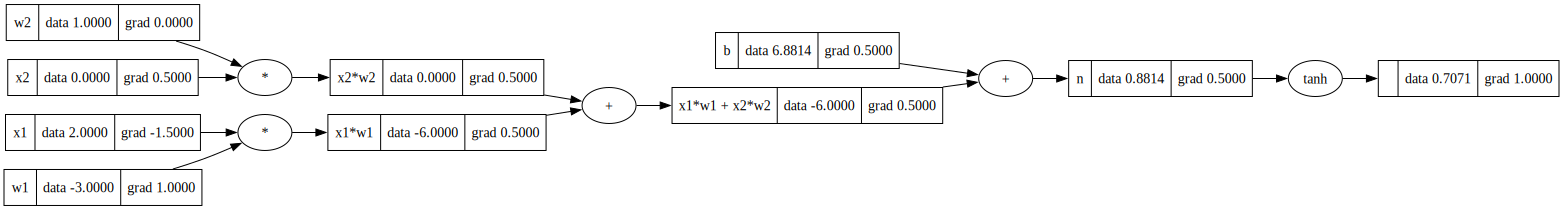

In [16]:
draw_dot(o)

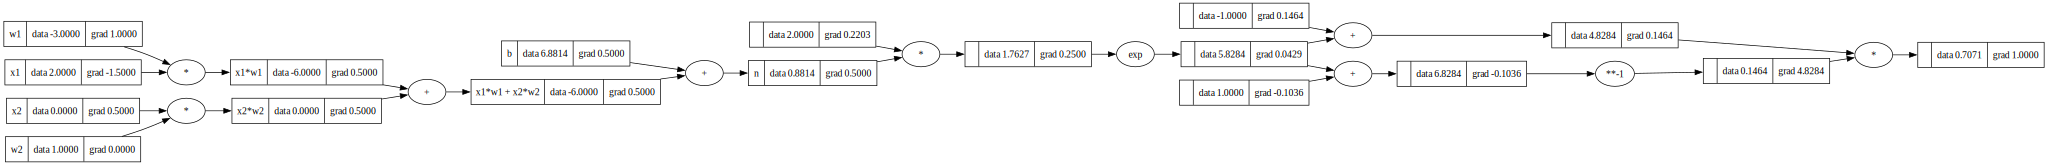

In [17]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b  = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)

In [18]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [19]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((xi * wi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

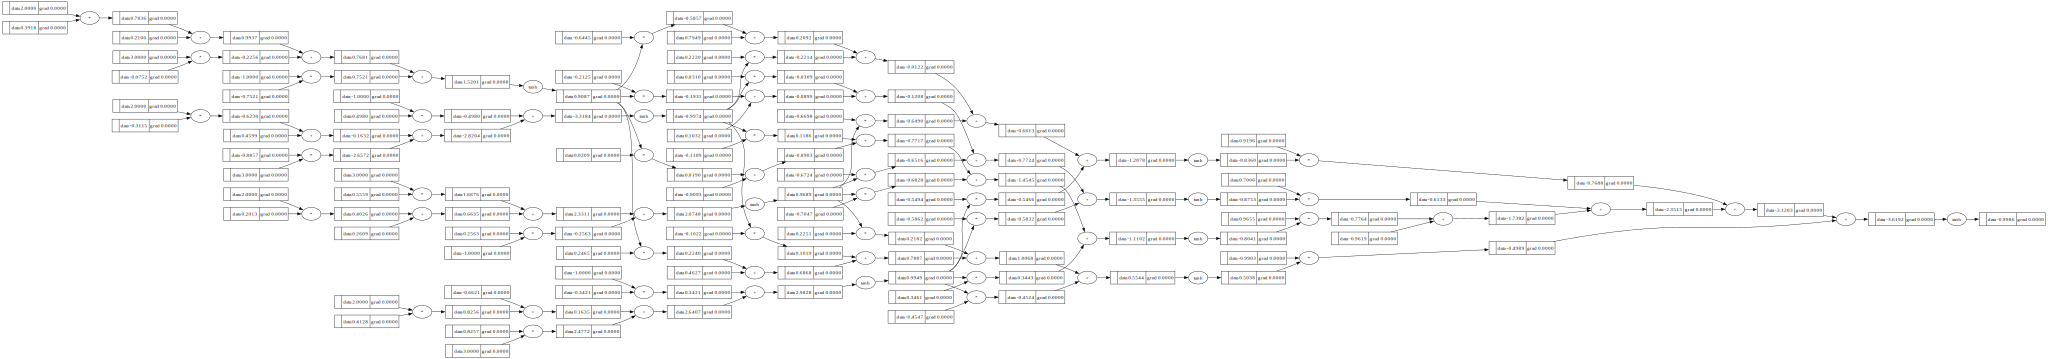

In [20]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
draw_dot(n(x))

In [21]:
len(n.parameters())

41

In [22]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [23]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.985043032610813)

In [24]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.985043032610813)

In [25]:
ypred

[Value(data=-0.9985641982744837),
 Value(data=-0.9785359126993193),
 Value(data=-0.9749626309942582),
 Value(data=-0.997422489383731)]

In [26]:
loss.backward()

In [27]:
n.layers[0].neurons[0].w[0].grad

0.002318687212183844

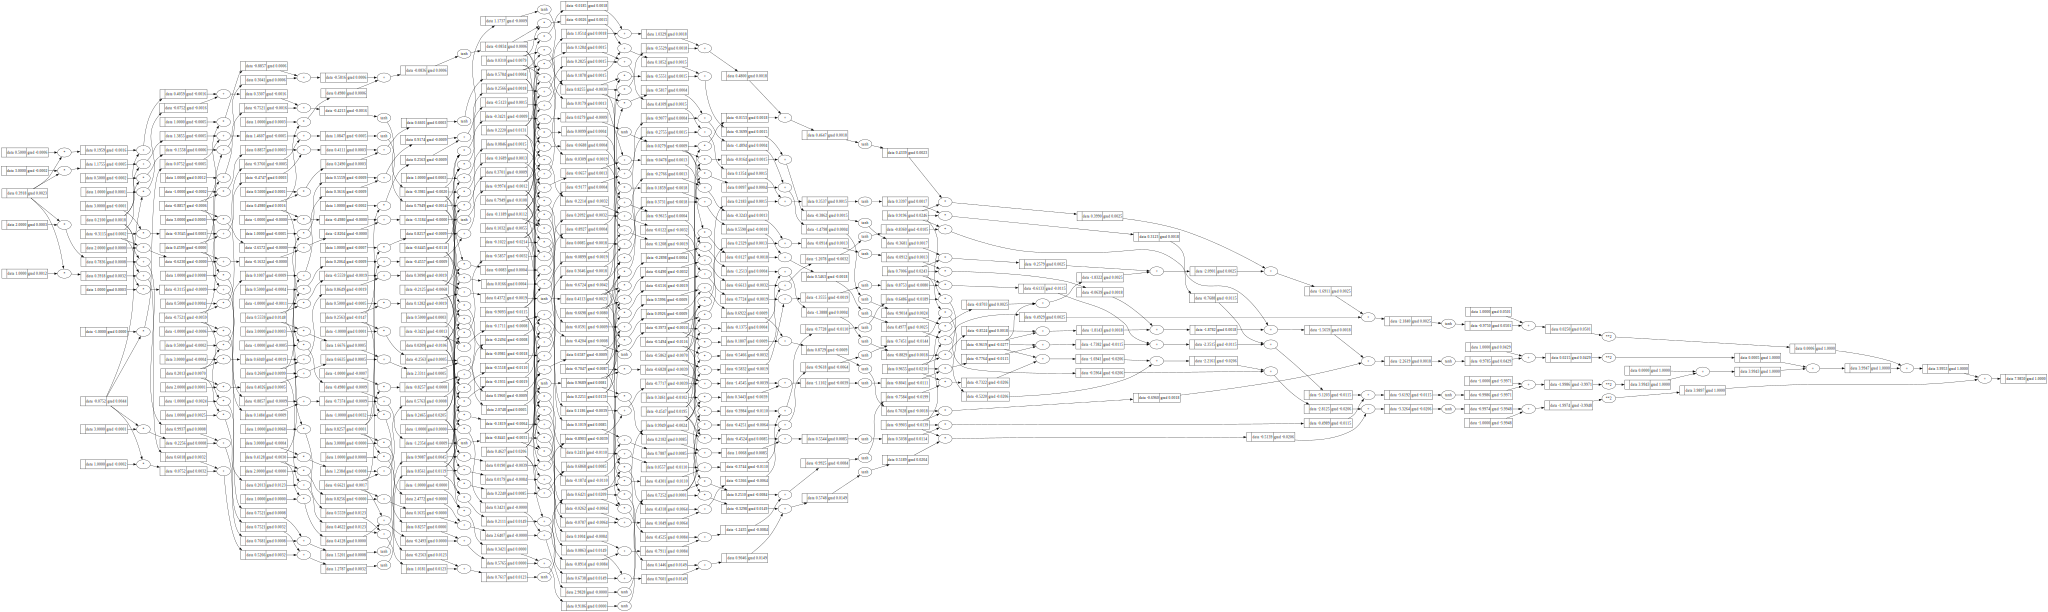

In [28]:
draw_dot(loss)

In [29]:
n.layers[0].neurons[0].w[0].data

0.39181976908972027

In [30]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [31]:
n.layers[0].neurons[0].w[0].data

0.39179658221759844

In [32]:
n = MLP(3, [4,4,1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

for k in range(100):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys,ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 7.349670919221472
1 4.4182932099237915
2 1.5526548168383103
3 0.9335486289423178
4 0.5462353946514334
5 0.28371195629120394
6 0.22381823520533
7 0.18385628923759656
8 0.1554078547362606
9 0.13419363773160195
10 0.11780734073646384
11 0.10479554483403661
12 0.09423050705710542
13 0.08549327627515235
14 0.07815569122124759
15 0.07191248345579536
16 0.066540357589146
17 0.0618723478563563
18 0.05778120234557679
19 0.05416830114117735
20 0.05095607628467769
21 0.04808271026336392
22 0.04549835403594607
23 0.043162380901243
24 0.04104136050424867
25 0.039107542449264135
26 0.03733770637847342
27 0.03571227946461186
28 0.03421465166702772
29 0.03283063904909008
30 0.03154805920756267
31 0.030356392485704195
32 0.029246509464381627
33 0.028210450124525468
34 0.02724124363332791
35 0.026332760320415524
36 0.02547958934941052
37 0.024676937042682808
38 0.02392054191460829
39 0.02320660330496428
40 0.02253172114641628
41 0.021892844897055036
42 0.021287230056220026
43 0.020712400985628873
44 0

In [33]:
ypred

[Value(data=0.9607227211315544),
 Value(data=-0.9494118402230229),
 Value(data=-0.9639761346707983),
 Value(data=0.9496503741691956)]